In [1]:
from mygo.datasets import *
from mygo.model import *
from torch.utils.data import DataLoader
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# initialization
torch.manual_seed(25565)  # for reproducibility
plt.style.use("dark_background")

In [3]:
train_data = MCTSDataset(
    root="../data",
    train=True,
)

test_data = MCTSDataset(
    root="../data",
    train=False,
)

In [4]:
# record for plotting
xs = []
train_losses, test_losses = [], []
train_accs, test_accs = [], []

In [5]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    batches = len(dataloader)
    train_loss, correct = 0.0, 0.0
    model.train()

    for i, (xs, ys) in enumerate(dataloader):
        optimizer.zero_grad()

        pred = model(xs)
        loss = loss_fn(pred, ys)

        train_loss += loss.item()
        correct += (pred.argmax(1) == ys.argmax(1)).type(torch.float).sum().item()

        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(f"loss: {loss.item():>7f} [{i + 1:>4d}/{batches:>4d}]")

    train_loss /= batches
    accuracy = correct / size * 100
    train_losses.append(train_loss)
    train_accs.append(accuracy)
    print(f"\nTrain: accuracy: {accuracy:>.3f}%, loss: {train_loss:>7f}")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    batches = len(dataloader)
    test_loss, correct = 0.0, 0.0
    model.eval()

    with torch.no_grad():
        for xs, ys in dataloader:
            pred = model(xs)
            test_loss += loss_fn(pred, ys).item()
            correct += (pred.argmax(1) == ys.argmax(1)).type(torch.float).sum().item()

    test_loss /= batches
    accuracy = correct / size * 100
    test_losses.append(test_loss)
    test_accs.append(accuracy)
    print(f"Test: accuracy: {accuracy:>.3f}%, loss: {test_loss:>7f}")

In [6]:
model = TinyModel(9)
print(model)

total_params = sum(p.numel() for p in model.parameters())
print(f"parameters: {total_params:,}")

TinyModel(
  (conv_stack): Sequential(
    (0): Conv2d(1, 48, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_stack): Sequential(
    (0): Linear(in_features=768, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=81, bias=True)
  )
)
parameters: 456,545


In [7]:
%%time

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
batch_size = 128
epoches = 100

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=2 * batch_size)

for i in range(epoches):
    xs.append(i)
    print(f"Epoch {i + 1}\n{'-' * 25}")
    train_loop(train_loader, model, loss_fn, optimizer)
    test_loop(test_loader, model, loss_fn)
    print()

Epoch 1
-------------------------
loss: 4.392902 [   1/ 292]
loss: 4.212837 [ 101/ 292]
loss: 4.001297 [ 201/ 292]

Train: accuracy: 2.933%, loss: 4.123700
Test: accuracy: 3.113%, loss: 4.027696

Epoch 2
-------------------------
loss: 3.953722 [   1/ 292]
loss: 3.985985 [ 101/ 292]
loss: 3.961726 [ 201/ 292]

Train: accuracy: 3.596%, loss: 4.011154
Test: accuracy: 4.344%, loss: 3.979387

Epoch 3
-------------------------
loss: 3.998597 [   1/ 292]
loss: 3.862218 [ 101/ 292]
loss: 4.080373 [ 201/ 292]

Train: accuracy: 4.188%, loss: 3.974997
Test: accuracy: 5.068%, loss: 3.944660

Epoch 4
-------------------------
loss: 3.896429 [   1/ 292]
loss: 3.987279 [ 101/ 292]
loss: 3.973785 [ 201/ 292]

Train: accuracy: 4.888%, loss: 3.939604
Test: accuracy: 6.202%, loss: 3.870362

Epoch 5
-------------------------
loss: 3.835647 [   1/ 292]
loss: 4.035671 [ 101/ 292]
loss: 3.931904 [ 201/ 292]

Train: accuracy: 5.880%, loss: 3.902835
Test: accuracy: 7.408%, loss: 3.834958

Epoch 6
------------

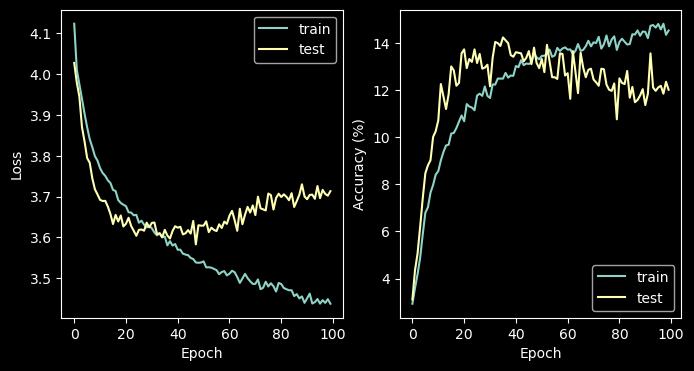

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy (%)")

axs[0].plot(xs, train_losses, label="train")
axs[0].plot(xs, test_losses, label="test")
axs[0].legend()
axs[1].plot(xs, train_accs, label="train")
axs[1].plot(xs, test_accs, label="test")
axs[1].legend()

plt.show()

In [9]:
torch.save(model.state_dict(), "../models/tiny_weights.pt")